In [1]:
import pickle
import pandas as pd
import warnings
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import optimize
import pickle
import statsmodels.api as sm
from scipy import stats

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
file_path = f'monthly_data/regression_data.pkl'
with open(file_path, 'rb') as file:
    flow=pickle.load(file)

In [3]:
flow

,Zips,2020_01,2022_01,2020_02,2022_02,2020_03,2022_03,2020_04,2022_04,2020_05,...,2020_08,2022_08,2020_09,2022_09,2020_10,2022_10,2020_11,2022_11,2020_12,2022_12
0,91405,129.982779,0.000000,178.443909,0,156.263772,0.0,90.756919,175.322709,86.284277,...,0,142.661362,0,145.779707,143.839915,197.782065,141.882348,199.399547,131.220538,164.758239
1,91401,139.107103,0.000000,189.231009,0,164.334335,0.0,92.905987,202.364708,88.626650,...,0,165.737387,0,155.121469,157.087497,235.327630,152.309292,231.970098,141.513462,200.611920
2,91402,174.760222,0.000000,223.134552,0,213.705532,0.0,140.449469,227.674508,130.499213,...,0,200.930970,0,181.821877,190.478402,258.337127,187.255434,262.442782,174.931811,234.013459
3,91605,139.635252,0.995261,184.639989,0,164.911861,0.0,100.790765,179.907723,101.333942,...,0,142.046943,0,135.347245,177.099141,212.036234,165.821314,218.133060,147.094950,188.350562
4,91331,126.797529,0.000000,159.963105,0,157.884212,0.0,103.354097,181.613320,97.990752,...,0,156.981598,0,143.517929,144.327235,206.011202,143.379136,210.856508,131.315111,188.622084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,13359,0.000000,1.493192,0.000000,0,0.000000,0.0,0.000000,157.520507,0.000000,...,0,119.836033,0,124.785419,0.000000,181.448094,0.000000,178.990854,0.000000,165.482951
163,90074,0.000000,0.000000,0.000000,0,0.000000,0.0,0.000000,126.346240,0.000000,...,0,110.614066,0,109.675211,0.000000,145.692026,0.000000,158.803196,0.000000,132.663538
164,90290,0.000000,0.000000,0.000000,0,0.000000,0.0,0.000000,123.281880,0.000000,...,0,95.203024,0,113.658797,0.000000,197.988931,0.000000,197.083797,0.000000,178.837250
165,90202,0.000000,0.000000,0.000000,0,0.000000,0.0,0.000000,60.796255,0.000000,...,0,56.499318,0,69.493186,0.000000,133.577730,0.000000,119.634181,0.000000,107.251762


In [4]:
#select 4,5,6,10,11,12
df = flow[['Zips','2020_04','2020_05','2020_06','2020_10','2020_11','2020_12','2022_04','2022_05','2022_06','2022_10','2022_11','2022_12']]
df=df[(df!=0).all(axis=1)]
diff_in_diff_local = {}
df_2020_04={}
df_2020_05={}
df_2020_06={}
df_2022_04={}
df_2022_05={}
df_2022_06={}
df_2020_10={}
df_2020_11={}
df_2020_12={}
df_2022_10={}
df_2022_11={}
df_2022_12={}
for i in df.index:
    lock_2020 = (df['2020_04'][i]+df['2020_05'][i]+df['2020_06'][i])
    post_2020 = (df['2020_10'][i]+df['2020_11'][i]+df['2020_12'][i])
    lock_2022 = (df['2022_04'][i]+df['2022_05'][i]+df['2022_06'][i])
    post_2022 = (df['2022_10'][i]+df['2022_11'][i]+df['2022_12'][i])
    value = (post_2020-lock_2020)-(post_2022-lock_2022)
    #value = (df['2022_04'][i]+df['2022_05'][i]+df['2022_06'][i]-df['2020_04'][i]-df['2020_05'][i]-df['2020_06'][i])#-(lock_2022-post_2022)
    #value = (df['2020_10'][i]+df['2020_11'][i]+df['2020_12'][i]-df['2020_04'][i]-df['2020_05'][i]-df['2020_06'][i])#-(lock_2022-post_2022)
    diff_in_diff_local[df['Zips'][i]] = value
    df_2020_04[df['Zips'][i]] = df['2020_04'][i]
    df_2020_05[df['Zips'][i]] = df['2020_05'][i]
    df_2020_06[df['Zips'][i]] = df['2020_06'][i]
    df_2022_04[df['Zips'][i]] = df['2022_04'][i]
    df_2022_05[df['Zips'][i]] = df['2022_05'][i]
    df_2022_06[df['Zips'][i]] = df['2022_06'][i] 
    df_2020_10[df['Zips'][i]] = df['2020_10'][i]
    df_2020_11[df['Zips'][i]] = df['2020_11'][i]
    df_2020_12[df['Zips'][i]] = df['2020_12'][i]
    df_2022_10[df['Zips'][i]] = df['2022_10'][i]
    df_2022_11[df['Zips'][i]] = df['2022_11'][i]
    df_2022_12[df['Zips'][i]] = df['2022_12'][i] 

In [5]:
censusdata = pickle.load( open( "diff_in_diff.p", "rb" ) )

In [6]:
len(set([str(i) for i in censusdata.zipcode.values]).intersection(set(df.Zips.values)))
#88 zipcodes are overlapped

88

In [7]:
censusdata

,zipcode,int1_2019,int2_2019,int3_2019,int4_2019,int1_2020,int2_2020,int3_2020,int4_2020,total,...,industry_12,industry_13,num_cars,diff1,diff2,diff3,diff4,diverse index,stable,diff_in_diff
0,91302,1.0,0.964655,178.509029,153.534878,1.039839,1.258441,289.934299,256.969282,26961.0,...,0.020,0.007,23082,-0.039839,-0.304550,-0.624200,-0.673687,0.371539,1,0.253947
1,90081,1.0,1.061654,208.606087,208.242668,1.165239,0.765542,188.217464,174.438031,NaN,...,NaN,NaN,46,-0.165239,0.278916,0.097737,0.162333,NaN,1,-0.461352
2,90022,1.0,1.114941,290.312798,278.805563,1.325561,0.990883,275.803424,255.592497,66168.0,...,0.050,0.033,42347,-0.325561,0.111269,0.049978,0.083259,0.077937,1,-0.449619
3,91754,1.0,1.158260,179.182143,122.168014,0.924705,0.451420,96.717009,89.887527,33343.0,...,0.051,0.048,26781,0.075295,0.610261,0.460231,0.264230,0.524533,1,-0.631546
4,91803,1.0,1.051115,169.587362,144.390786,1.072864,0.724259,141.648980,130.191937,30093.0,...,0.054,0.069,23535,-0.072864,0.310962,0.164743,0.098336,0.591551,1,-0.399721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,91312,1.0,1.088705,165.407148,143.783374,1.073354,0.823157,138.957907,134.458675,NaN,...,NaN,NaN,3,-0.073354,0.243912,0.159904,0.064852,NaN,1,-0.338902
215,91326,1.0,1.050365,121.357683,110.829104,1.011052,0.675520,92.511048,115.207322,36126.0,...,0.047,0.048,30323,-0.011052,0.356871,0.237699,-0.039504,0.700425,1,-0.385897
216,91361,1.0,0.900041,160.307107,144.757900,0.998872,0.667419,147.119061,154.095239,19953.0,...,0.027,0.020,18914,0.001128,0.258457,0.082267,-0.064503,0.360755,1,-0.231494
217,90670,1.0,0.943013,206.684383,201.427176,0.946471,0.790467,201.219890,190.069540,16410.0,...,0.039,0.057,20905,0.053529,0.161765,0.026439,0.056386,0.430550,1,-0.099018


In [8]:
new_diff = []
value_2020_04 = []
value_2020_05 = []
value_2020_06 = []
value_2022_04 = []
value_2022_05 = []
value_2022_06 = []
value_2020_10 = []
value_2020_11 = []
value_2020_12 = []
value_2022_10 = []
value_2022_11 = []
value_2022_12 = []

for i in censusdata.index:
    if str(censusdata['zipcode'][i]) in diff_in_diff_local:
        new_diff.append(diff_in_diff_local[str(censusdata['zipcode'][i])])
        value_2020_04.append(df_2020_04[str(censusdata['zipcode'][i])])
        value_2020_05.append(df_2020_05[str(censusdata['zipcode'][i])])
        value_2020_06.append(df_2020_06[str(censusdata['zipcode'][i])])
        value_2022_04.append(df_2022_04[str(censusdata['zipcode'][i])])
        value_2022_05.append(df_2022_05[str(censusdata['zipcode'][i])])
        value_2022_06.append(df_2022_06[str(censusdata['zipcode'][i])])
        value_2020_10.append(df_2020_10[str(censusdata['zipcode'][i])])
        value_2020_11.append(df_2020_11[str(censusdata['zipcode'][i])])
        value_2020_12.append(df_2020_12[str(censusdata['zipcode'][i])])
        value_2022_10.append(df_2022_10[str(censusdata['zipcode'][i])])
        value_2022_11.append(df_2022_11[str(censusdata['zipcode'][i])])
        value_2022_12.append(df_2022_12[str(censusdata['zipcode'][i])])
    else:
        new_diff.append(0)
        value_2020_04.append(0)
        value_2020_05.append(0)
        value_2020_06.append(0)
        value_2022_04.append(0)
        value_2022_05.append(0)
        value_2022_06.append(0)
        value_2020_10.append(0)
        value_2020_11.append(0)
        value_2020_12.append(0)
        value_2022_10.append(0)
        value_2022_11.append(0)
        value_2022_12.append(0)
new_diff = pd.Series(new_diff,index=censusdata.index)
censusdata['new_diff'] = new_diff
value_2020_04 = pd.Series(value_2020_04,index=censusdata.index)
censusdata['value_2020_04'] = value_2020_04
value_2020_05 = pd.Series(value_2020_05,index=censusdata.index)
censusdata['value_2020_05'] = value_2020_05
value_2020_06 = pd.Series(value_2020_06,index=censusdata.index)
censusdata['value_2020_06'] = value_2020_06
value_2022_04 = pd.Series(value_2022_04,index=censusdata.index)
censusdata['value_2022_04'] = value_2022_04
value_2022_05 = pd.Series(value_2022_05,index=censusdata.index)
censusdata['value_2022_05'] = value_2022_05
value_2022_06 = pd.Series(value_2022_06,index=censusdata.index)
censusdata['value_2022_06'] = value_2022_06

value_2020_10 = pd.Series(value_2020_10,index=censusdata.index)
censusdata['value_2020_10'] = value_2020_10
value_2020_11 = pd.Series(value_2020_11,index=censusdata.index)
censusdata['value_2020_11'] = value_2020_11
value_2020_12 = pd.Series(value_2020_12,index=censusdata.index)
censusdata['value_2020_12'] = value_2020_12
value_2022_10 = pd.Series(value_2022_10,index=censusdata.index)
censusdata['value_2022_10'] = value_2022_10
value_2022_11 = pd.Series(value_2022_11,index=censusdata.index)
censusdata['value_2022_11'] = value_2022_11
value_2022_12 = pd.Series(value_2022_12,index=censusdata.index)
censusdata['value_2022_12'] = value_2022_12
censusdata=censusdata[censusdata['new_diff']!=0]

In [9]:
censusdata=censusdata.dropna()

In [10]:
censusdata

,zipcode,int1_2019,int2_2019,int3_2019,int4_2019,int1_2020,int2_2020,int3_2020,int4_2020,total,...,value_2020_06,value_2022_04,value_2022_05,value_2022_06,value_2020_10,value_2020_11,value_2020_12,value_2022_10,value_2022_11,value_2022_12
4,91803,1.0,1.051115,169.587362,144.390786,1.072864,0.724259,141.648980,130.191937,30093.0,...,244.029016,372.812706,331.421178,367.362126,367.936579,359.798289,341.016290,391.530696,325.414027,126.541187
11,90023,1.0,1.002597,335.358998,310.251052,0.953115,0.639527,283.469489,257.874742,46517.0,...,71.275194,111.561056,125.469325,137.521075,88.186270,87.517205,80.410179,128.626903,132.018842,120.708922
12,90230,1.0,1.005279,191.466114,185.861696,0.945038,0.564788,171.334681,160.941943,33135.0,...,98.590119,179.857835,167.119771,204.281197,165.265728,165.000322,150.417552,217.423327,217.886061,219.881228
14,90026,1.0,0.973244,236.896074,209.306833,0.905527,1.232647,310.336200,181.074228,67657.0,...,78.563443,171.315777,160.651555,175.042202,132.264847,128.241598,113.870084,193.452044,184.019377,169.163906
16,90041,1.0,0.981632,178.200528,160.335448,0.996742,0.575720,150.268546,151.323682,29888.0,...,71.988493,88.734552,169.324862,156.962133,100.273341,99.098090,83.259340,175.074204,181.107635,122.236840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,90029,1.0,0.873290,212.508916,202.266398,0.937985,0.657117,198.590739,172.737905,36126.0,...,99.045275,196.915490,186.869897,200.914295,158.362955,152.097695,137.685818,211.164089,210.478857,200.404562
209,90064,1.0,1.043418,234.832384,209.613801,0.972180,0.619813,214.990277,213.989962,25988.0,...,106.485918,219.988090,212.088284,231.198091,185.414329,176.502279,160.854441,251.935343,259.471791,231.507893
210,90042,1.0,1.035768,138.850715,131.813002,1.179548,0.589504,103.140850,114.942108,60509.0,...,49.523245,89.751492,89.460171,85.759789,63.419727,67.777072,60.113436,98.833814,104.283566,86.375012
215,91326,1.0,1.050365,121.357683,110.829104,1.011052,0.675520,92.511048,115.207322,36126.0,...,65.576978,149.940516,140.399192,148.532400,110.176337,109.164177,100.352011,177.167000,181.648533,157.052530


# Draw the map

In [0]:
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(100,100))
%matplotlib inline
shp_path = "./zips.shp"
sf = shp.Reader(shp_path)
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df
df = read_shapefile(sf)
def calc_color(data, color=None):
        if color   == 1: 
            color_sq =  ['#dadaebFF','#bcbddcF0','#9e9ac8F0',
                        '#807dbaF0','#6a51a3F0','#54278fF0']; 
            colors = 'Purples';
        elif color == 2: 
            color_sq = ['#c7e9b4','#7fcdbb','#41b6c4',
                        '#1d91c0','#225ea8','#253494']; 
            colors = 'YlGnBu';
        elif color == 3: 
            color_sq = ['#f7f7f7','#d9d9d9','#bdbdbd',
                        '#969696','#636363','#252525']; 
            colors = 'Greys';
        elif color == 9: 
            color_sq = ['#ff0000','#ff0000','#ff0000',
                        '#ff0000','#ff0000','#ff0000']
        else:            
            color_sq = ['#ffffd4','#fee391','#fec44f',
                        '#fe9929','#d95f0e','#993404']; 
            colors = 'YlOrBr';
        new_data, bins = pd.qcut(data, 6, retbins=True, 
        labels=list(range(6)))
        color_ton = []
        for val in new_data:
            color_ton.append(color_sq[val]) 
        if color != 9:
            colors = sns.color_palette(colors, n_colors=6)
            sns.palplot(colors, 0.6);
            for i in range(6):
                print ("\n"+str(i+1)+': '+str(bins[i])+
                       " => "+str(bins[i+1]), end =" ")
            print("\n\n   1   2   3   4   5   6")    
        return color_ton, bins;
def plot_comunas_data(sf, title, comunas, data=None, 
                      color=None, print_id=False):
    '''
    Plot map with selected comunes, using specific color
    '''
    
    color_ton, bins = calc_color(data, color)
    df = read_shapefile(sf)
    comuna_id = []
    for i in comunas:
        if i not in df.zipcode.values:
            continue
        comuna_id.append(df[df['zipcode']==i].index[0])
    plot_map_fill_multiples_ids_tone(sf, title, comuna_id, 
                                     print_id, 
                                     color_ton, 
                                     bins, 
                                     x_lim = (-119,-117.6) ,# latitude 
                                     y_lim = (33.6, 35), 
                                     figsize = (11,9));
def plot_map_fill_multiples_ids_tone(sf, title, comuna,  
                                     print_id, color_ton, 
                                     bins, 
                                     x_lim = (-119,-117.6), 
                                     y_lim = (33.6, 35), 
                                     figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
        
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
    for id in comuna:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color_ton[comuna.index(id)])
        if print_id != False:
            x0 = np.mean(x_lon)
            y0 = np.mean(y_lat)
            plt.text(x0, y0, id, fontsize=10)
    plt.xlim(-119,-117.6)
    plt.ylim(33.6, 35)
print_id = False # The shape id will be printed
color_pallete = 0 # 'Purples'
south = [str(i) for i in censusdata['zipcode']]
datax = [i for i in censusdata['new_diff']]
plot_comunas_data(sf, 'Traffic Increase', south, datax, color_pallete, print_id)

NameError: name 'pd' is not defined

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '2020,4'),
  Text(1, 0, '2022,4'),
  Text(2, 0, '2020,5'),
  Text(3, 0, '2022,5'),
  Text(4, 0, '2020,6'),
  Text(5, 0, '2022,6'),
  Text(6, 0, '2020,10'),
  Text(7, 0, '2022,10'),
  Text(8, 0, '2020,11'),
  Text(9, 0, '2022,11'),
  Text(10, 0, '2020,12'),
  Text(11, 0, '2022,12')])

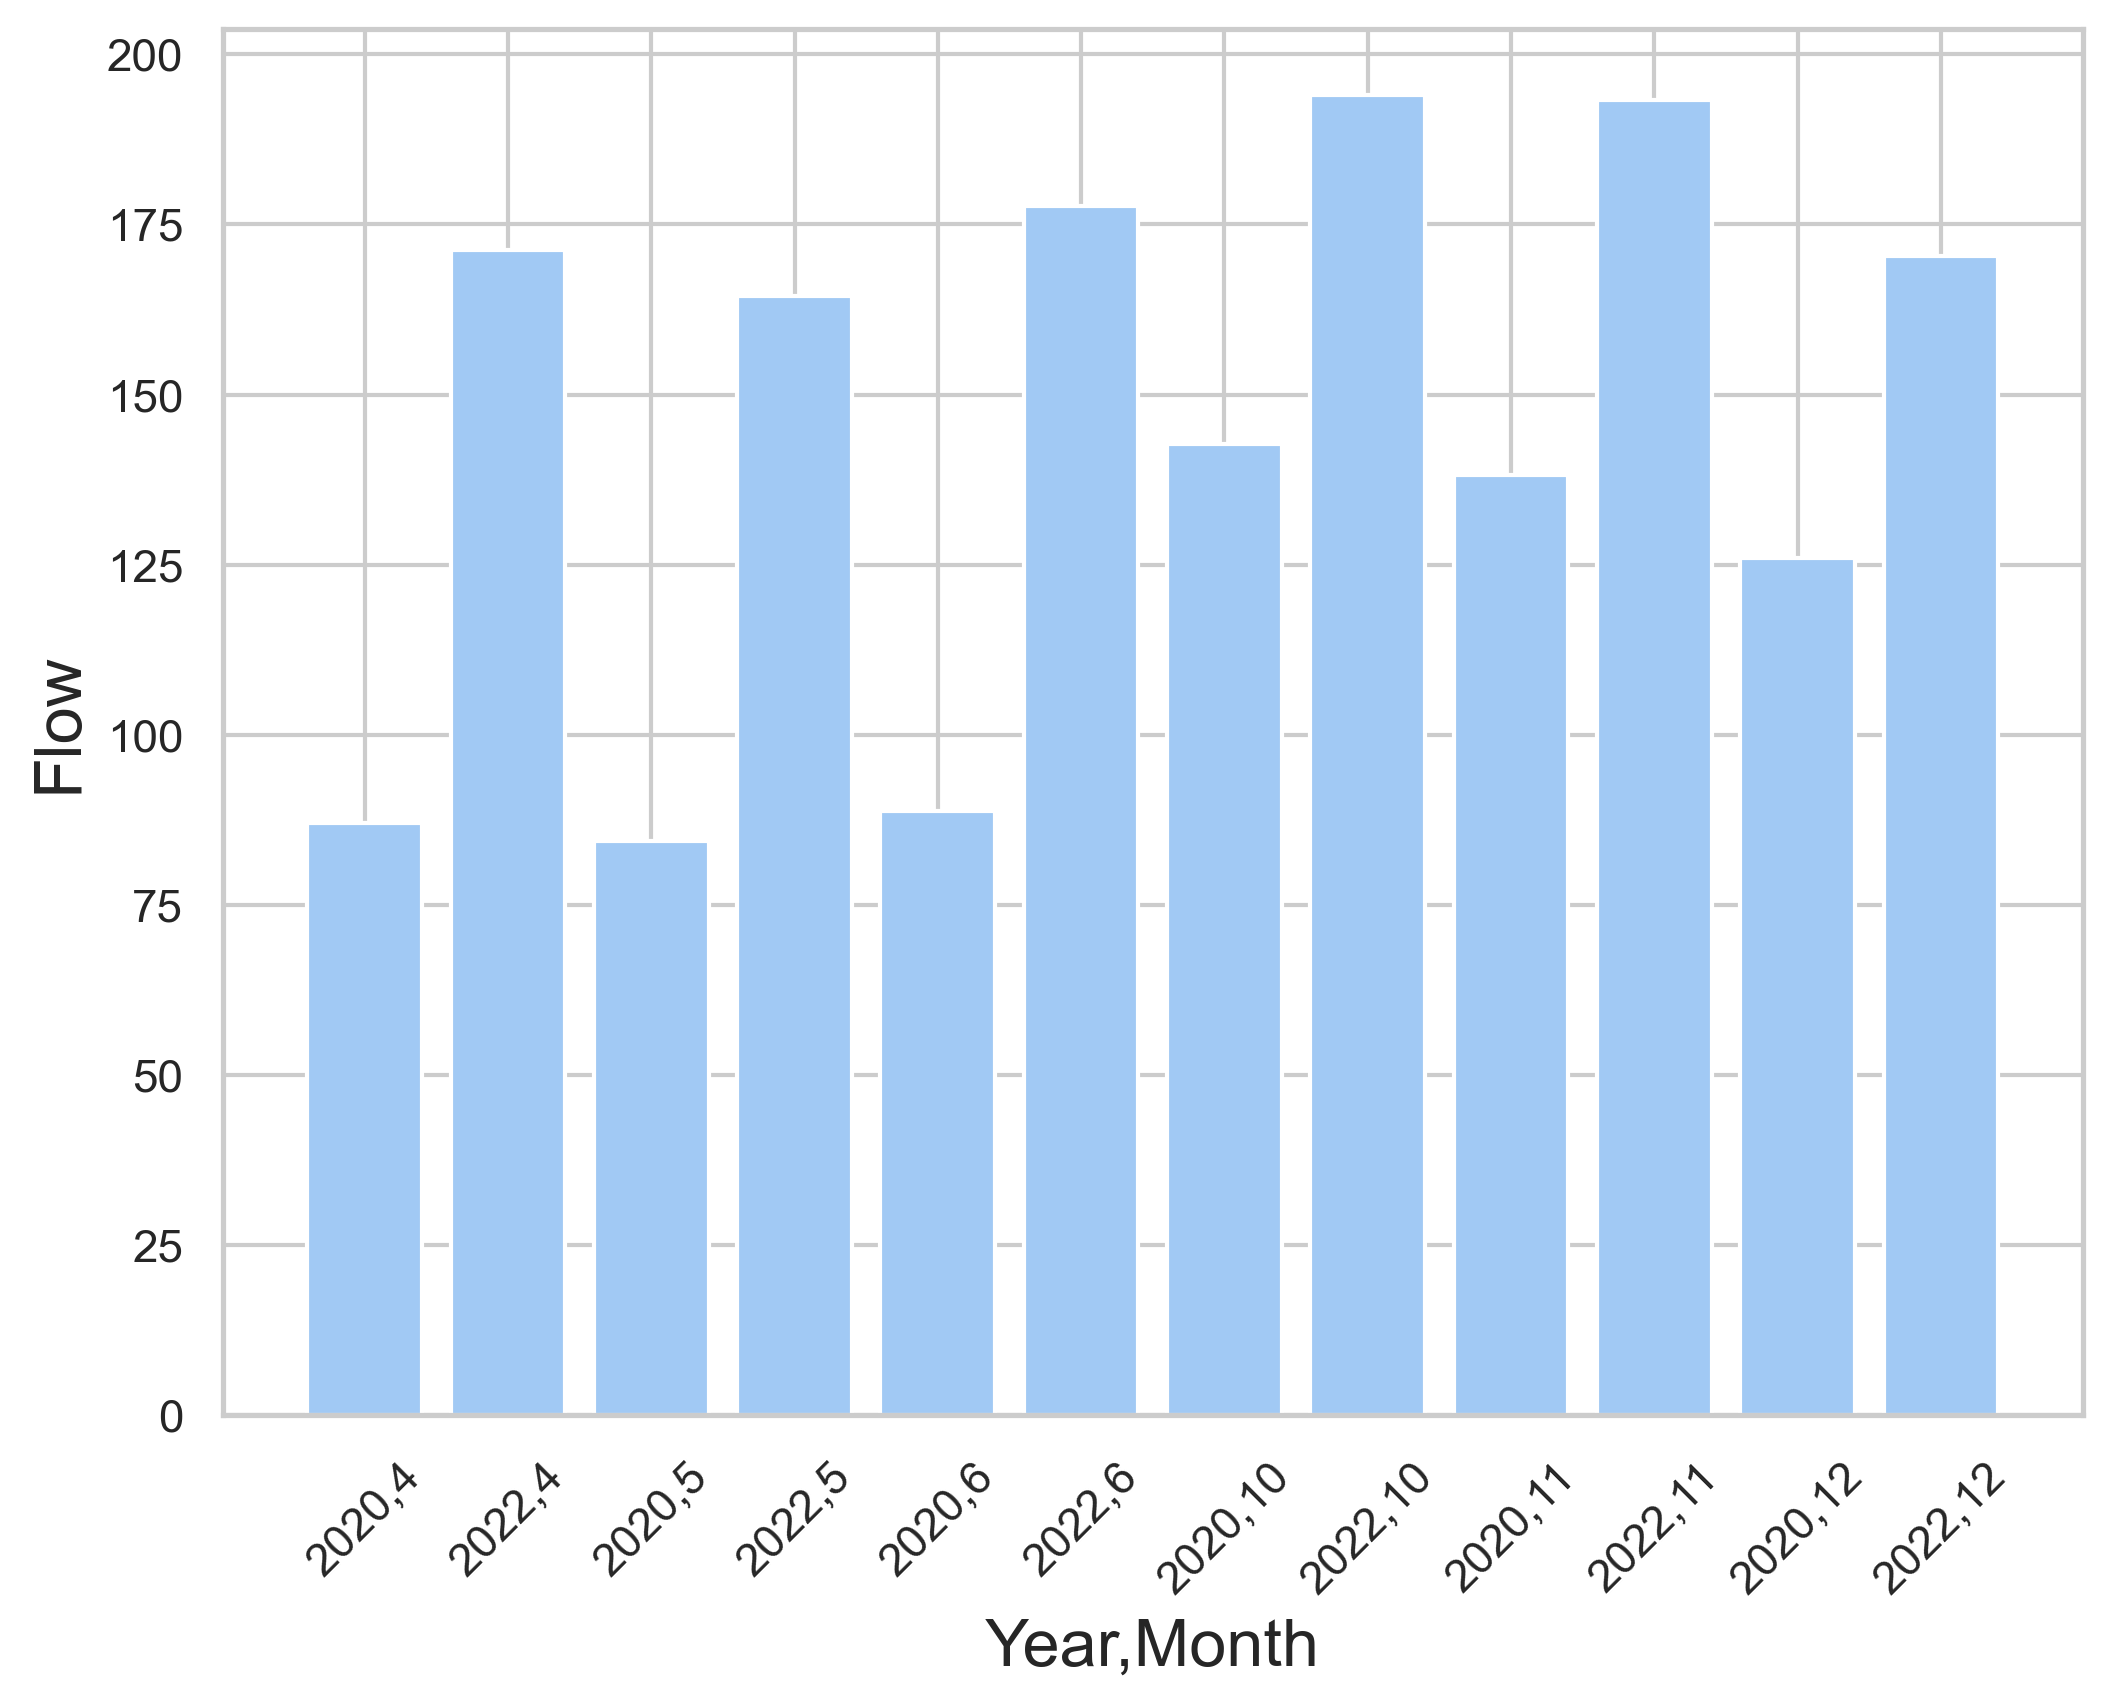

In [11]:
f20204 = np.mean(censusdata['value_2020_04'])
f20205 = np.mean(censusdata['value_2020_05'])
f20206 = np.mean(censusdata['value_2020_06'])
f20224 = np.mean(censusdata['value_2022_04'])
f20225 = np.mean(censusdata['value_2022_05'])
f20226 = np.mean(censusdata['value_2022_06'])
f202010 = np.mean(censusdata['value_2020_10'])
f202011 = np.mean(censusdata['value_2020_11'])
f202012 = np.mean(censusdata['value_2020_12'])
f202210 = np.mean(censusdata['value_2022_10'])
f202211 = np.mean(censusdata['value_2022_11'])
f202212 = np.mean(censusdata['value_2022_12'])
names = ['2020,4','2022,4','2020,5','2022,5','2020,6','2022,6','2020,10','2022,10','2020,11','2022,11','2020,12','2022,12']
plt.figure(figsize=(8, 6), dpi=300)
plt.bar(names,[f20204,f20224,f20205,f20225,f20206,f20226,f202010,f202210,f202011,f202211,f202012,f202212])
plt.xlabel('Year,Month',fontsize=16)
plt.ylabel('Flow',fontsize=16)
#plt.title('Bar Plot Example')

plt.xticks(rotation=45)  # Rotate the x-axis labels if needed

# Adding interaction


In [12]:
regress_vars= ['total','employed_ratio','median income (dollars)','hispanic_ratio','black_ratio','asian_ratio','other_ratio','population density','diverse index'
,'commuting_drove_alone','commuting_carpool','commuting_public','commuting_walked','commuting_at_home','commuting_time'
,'class_private_wage','class_government','class_self'
,'industry_1','industry_2','industry_3','industry_4','industry_5','industry_6','industry_7','industry_8','industry_9','industry_10','industry_11','industry_12'
,'num_cars']
length = len(regress_vars)
for i in range(length):
    for j in range(i,length):
        if i < j:
            var_1 = regress_vars[i]
            var_2 = regress_vars[j]
            censusdata[var_1+'*'+var_2] = censusdata[var_1]*censusdata[var_2]
            regress_vars.append(var_1+'*'+var_2)

/var/folders/b3/kkdtnh4d4gjgrk45d_yrf4100000gn/T/ipykernel_24895/1103947127.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  censusdata[var_1+'*'+var_2] = censusdata[var_1]*censusdata[var_2]
/var/folders/b3/kkdtnh4d4gjgrk45d_yrf4100000gn/T/ipykernel_24895/1103947127.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  censusdata[var_1+'*'+var_2] = censusdata[var_1]*censusdata[var_2]
/var/folders/b3/kkdtnh4d4gjgrk45d_yrf4100000gn/T/ipykernel_24895/1103947127.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is 

In [13]:
data1p = [i for i in censusdata['total']]
data1e = [i for i in censusdata['employed_ratio']]
data1i = [i for i in censusdata['median income (dollars)']]
data1w = [i for i in censusdata['hispanic_ratio']]
data1b = [i for i in censusdata['black_ratio']]
data1a = [i for i in censusdata['asian_ratio']]
data1h = [i for i in censusdata['other_ratio']]
data1d = [i for i in censusdata['population density']]
data1di = [i for i in censusdata['diverse index']]
#data1int = [i for i in censusdata['interaction']]
'''
data1c1 = [i for i in censusdata['commuting_drove_alone']]
data1c2 = [i for i in censusdata['commuting_carpool']]
data1c3 = [i for i in censusdata['commuting_public']]
data1c4 = [i for i in censusdata['commuting_walked']]
data1c5 = [i for i in censusdata['commuting_at_home']]
data1c6 = [i for i in censusdata['commuting_time']]

data1cl1 = [i for i in censusdata['class_private_wage']]
data1cl2 = [i for i in censusdata['class_government']]
data1cl3 = [i for i in censusdata['class_self']]

data1car = [i for i in censusdata['num_cars']]
'''

data1traffic = np.array([i for i in censusdata['new_diff']])

#train = np.array([data1p,data1e,data1i,data1w,data1b,data1a,data1h,data1d,data1di,
#                  data1c1,data1c2,data1c3,data1c4,data1c5,data1c6,
#                  data1cl1,data1cl2,data1cl3,data1car]).T 
train = np.array([data1p,data1e,data1i,data1w,data1b,data1a,data1h,data1d,data1di]).T 

train = sm.add_constant(train)
lr1 = sm.OLS(data1traffic ,train).fit()

#lr1.summary(xname=['const','total population', 'employment ratio','median income', 'hispanic proportion', 'black proportion', 'asian proportion', 'other proportion','population density','diverse index','drove alone','carpool','public','walked','at home','time','private wage','government','self','cars'])
lr1.summary(xname=['const','total population', 'employment ratio','median income', 'hispanic proportion', 'black proportion', 'asian proportion', 'other proportion','population density','diverse index'])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                    0.6420
Date:                Tue, 19 Sep 2023   Prob (F-statistic):              0.757
Time:                        11:32:40   Log-Likelihood:                -475.81
No. Observations:                  79   AIC:                             971.6
Df Residuals:                      69   BIC:                             995.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -209.3504    700.811     -0.299      0.766   -1607.430    1188.730
total population        0.0004      0.001      0.532      0.596      -0.001       0.002
employment ratio      478.5191    808.832      0.592      0.556   -1135.057    2092.095
median income          -0.0007      0.001     -0.717      0.476      -0.003       0.001
hispanic proportion  -139.1304    116.433     -1.195      0.236    -371.409      93.148
black proportion      194.6888    159.167      1.223      0.225    -122.841     512.219
asian proportion      126.9668    150.902      0.841      0.403    -174.075     428.009
other proportion     -994.7624   1169.030     -0.851      0.398   -3326.914    1337.389
population density     -0.0011      0.002     -0.480      0.633      -0.006       0.003
diverse index         -38.6337    142.511     -0.271      0.787    -322.935     245.668
==============================================================================
Omnibus:                       80.903   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              795.107
Skew:                           3.109   Prob(JB):                    2.21e-173
Kurtosis:                      17.244   Cond. No.                     8.45e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
data1p = [i for i in censusdata['total']]
data1e = [i for i in censusdata['employed_ratio']]
data1i = [i for i in censusdata['median income (dollars)']]
data1w = [i for i in censusdata['hispanic_ratio']]
data1b = [i for i in censusdata['black_ratio']]
data1a = [i for i in censusdata['asian_ratio']]
data1h = [i for i in censusdata['other_ratio']]
data1d = [i for i in censusdata['population density']]
data1di = [i for i in censusdata['diverse index']]

data1c1 = [i for i in censusdata['commuting_drove_alone']]
data1c2 = [i for i in censusdata['commuting_carpool']]
data1c3 = [i for i in censusdata['commuting_public']]
data1c4 = [i for i in censusdata['commuting_walked']]
data1c5 = [i for i in censusdata['commuting_at_home']]
data1c6 = [i for i in censusdata['commuting_time']]

data1cl1 = [i for i in censusdata['class_private_wage']]
data1cl2 = [i for i in censusdata['class_government']]
data1cl3 = [i for i in censusdata['class_self']]

data1i1 = [i for i in censusdata['industry_1']]
data1i2 = [i for i in censusdata['industry_2']]
data1i3 = [i for i in censusdata['industry_3']]
data1i4 = [i for i in censusdata['industry_4']]
data1i5 = [i for i in censusdata['industry_5']]
data1i6 = [i for i in censusdata['industry_6']]
data1i7 = [i for i in censusdata['industry_7']]
data1i8 = [i for i in censusdata['industry_8']]
data1i9 = [i for i in censusdata['industry_9']]
data1i10 = [i for i in censusdata['industry_10']]
data1i11 = [i for i in censusdata['industry_11']]
data1i12 = [i for i in censusdata['industry_12']]

data1car = [i for i in censusdata['num_cars']]



data1traffic = np.array([i for i in censusdata['new_diff']])

train = np.array([data1p,data1e,data1i,data1w,data1b,data1a,data1h,data1d,data1di,
                  data1c1,data1c2,data1c3,data1c4,data1c5,data1c6,
                  data1cl1,data1cl2,data1cl3,
                 data1i1,data1i2,data1i3,data1i4,data1i5,data1i6,data1i7,data1i8,data1i9,data1i10,data1i11,data1i12,data1car]).T 

train = sm.add_constant(train)
lr1 = sm.OLS(data1traffic ,train).fit()

lr1.summary(xname=['const','total population', 'employment ratio','median income', 'hispanic proportion', 'black proportion', 'asian proportion', 'other proportion','population density','diverse index','drove alone','carpool','public','walked','at home','time','private wage','government','self','1','2','3','4','5','6','7','8','9','10','11','12','cars'])

#1:Agriculture, forestry, fishing and hunting, and mining
#2:Construction
#3:Manufacturing
#4:Wholesale trade
#5:Retail trade
#6:Transportation and warehousing, and utilities
#7:Information
#8:Finance and insurance, and real estate and rental and leasing
#9:Professional, scientific, and management, and administrative and waste management services
#10:Educational services, and health care and social assistance
#11:Arts, entertainment, and recreation, and accommodation and food services
#12:Other services, except public administration
#13:Public administration

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                 -0.057
Method:                 Least Squares   F-statistic:                    0.8635
Date:                Tue, 19 Sep 2023   Prob (F-statistic):              0.663
Time:                        11:32:40   Log-Likelihood:                -461.18
No. Observations:                  79   AIC:                             986.4
Df Residuals:                      47   BIC:                             1062.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.081e+04   1.03e+04      1.050      0.299   -9910.141    3.15e+04
total population        0.0002      0.001      0.153      0.879      -0.002       0.003
employment ratio      798.7934   1115.904      0.716      0.478   -1446.116    3043.702
median income           0.0002      0.001      0.129      0.898      -0.002       0.003
hispanic proportion  -435.5476    225.489     -1.932      0.059    -889.173      18.078
black proportion     -149.9889    270.595     -0.554      0.582    -694.357     394.379
asian proportion     -162.6808    259.821     -0.626      0.534    -685.373     360.012
other proportion    -3494.1076   1622.095     -2.154      0.036   -6757.341    -230.874
population density     -0.0029      0.005     -0.621      0.538      -0.012       0.007
diverse index          80.8135    207.527      0.389      0.699    -336.677     498.304
drove alone          -515.0808   1174.848     -0.438      0.663   -2878.570    1848.408
carpool              -230.4451   1673.188     -0.138      0.891   -3596.465    3135.574
public               -172.1279   1599.730     -0.108      0.915   -3390.370    3046.114
walked              -1240.4928   1300.140     -0.954      0.345   -3856.036    1375.051
at home              -743.6203   1565.137     -0.475      0.637   -3892.270    2405.029
time                   -3.9827      7.724     -0.516      0.609     -19.521      11.556
private wage        -1.172e+04   8923.163     -1.313      0.195   -2.97e+04    6231.518
government          -1.207e+04   9233.888     -1.308      0.197   -3.06e+04    6502.480
self                -1.325e+04   8982.128     -1.476      0.147   -3.13e+04    4816.082
1                    -612.5776   5226.401     -0.117      0.907   -1.11e+04    9901.585
2                    1066.3768   3008.643      0.354      0.725   -4986.232    7118.986
3                    1241.5000   2489.163      0.499      0.620   -3766.049    6249.049
4                     281.2974   3035.473      0.093      0.927   -5825.287    6387.882
5                    1440.1232   2853.417      0.505      0.616   -4300.212    7180.458
6                    3177.8765   2722.279      1.167      0.249   -2298.642    8654.395
7                     859.8439   2687.798      0.320      0.750   -4547.308    6266.996
8                    1080.0035   2786.225      0.388      0.700   -4525.159    6685.166
9                    1272.5006   2463.177      0.517      0.608   -3682.773    6227.774
10                   1118.2368   2350.118      0.476      0.636   -3609.590    5846.063
11                   2921.1496   2542.517      1.149      0.256   -2193.736    8036.035
12                    606.1468   2931.374      0.207      0.837   -5291.018    6503.311
cars                   -0.0002      0.001     -0.142      0.888      -0.003       0.002
===

In [15]:
correlation_matrix = censusdata.corr()
length = len(regress_vars)
regress_vars2 = regress_vars.copy()
for v in range(length):
    for u in range(v,length):
        if u != v:
            if correlation_matrix[regress_vars2[u]][regress_vars2[v]]>0.7:
                if regress_vars2[u] in regress_vars:
                    if regress_vars2[v] in regress_vars:
                        regress_vars.remove(regress_vars2[v])
X = censusdata[[i for i in regress_vars]]
X = sm.add_constant(X)  # Add a constant (intercept)

y = censusdata['new_diff']

model = sm.OLS(y, X).fit()
print(model.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:               new_diff   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1.118
Date:                Tue, 19 Sep 2023   Prob (F-statistic):              0.378
Time:                        11:32:40   Log-Likelihood:                -438.47
No. Observations:                  79   AIC:                             974.9
Df Residuals:                      30   BIC:                             1091.
Df Model:                          48                                         
Covariance Type:            nonrobust  